<a href="https://colab.research.google.com/github/sabrybenamor/ML-PROJECTS/blob/main/wall_robot_navigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openml

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 48.7 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=9850867f30b4ed5eaa8b80c660b82bb54efd8eb80746dcade935f3288ec4cf7f
  Stored in directory: /root/.cache/pip/wheels/00/23/31/5e562fce1f95aabe57f2a7320d07433ba1cd152bcde2f6a002
Successfully built liac-arff


In [359]:
import pandas as pd  # Data handling
import numpy as np    # Numerical operations

import matplotlib.pyplot as plt  # Plotting
import seaborn as sns            # Visualization

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split  # Split data
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Feature scaling, encoding
from sklearn.metrics import accuracy_score, confusion_matrix  # Evaluation metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [360]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
import openml  # OpenML library for accessing machine learning datasets

# Fetch the dataset with ID 1497 from OpenML
dataset = openml.datasets.get_dataset(1497)

# Retrieve the data as a pandas DataFrame
df, *_ = dataset.get_data()

# Display the last 5 rows of the DataFrame
print(df.tail())

In [ ]:
#show data info
print("Data shape :")
print(df.shape)
print("Data info :")
print(df.info)
print("\nMissing Values:")
print(df.isnull().sum())

In [ ]:
# Class distribution
target_column='Class'
plt.figure(figsize=(8, 6))
sns.countplot(x=target_column, data=df, order=df[target_column].value_counts().index)

plt.title('Class Distribution of Direction')
plt.xlabel('direction')
plt.ylabel('Count')

plt.show()

In [ ]:
# Select sensor columns V1 to V24
sensor_cols = [f'V{i}' for i in range(1, 25)]

# Compute mean of each sensor per class (direction), and transpose for plotting
means = df.groupby('Class')[sensor_cols].mean().T

# Plot mean sensor values for each class as grouped bar chart
means.plot(kind='bar', figsize=(20, 8))
plt.title('Mean Sensor Readings by Direction')
plt.ylabel('Mean Value')
plt.xlabel('Sensor')
plt.legend(title='Direction')
plt.tight_layout()
plt.show()
plt.savefig("mean_sensor_readings.png")

In [ ]:
plt.figure(figsize=(18, 10))
corr = df.drop(columns=['Class']).corr()  # Compute correlation matrix without 'Class' column
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Sensor Readings')
plt.show()

In [366]:
X = df[sensor_cols].values
y = df['Class'].values

# Ensure y is a 1D array of shape (n_samples,)
y = np.asarray(y).flatten()

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert y_train and y_test to integer type
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# One-hot encode the targets (assuming classes are 1-based: 1, 2, 3, 4)
y_train_cat = to_categorical(y_train - 1, num_classes=4).astype(np.float32)
y_test_cat = to_categorical(y_test - 1, num_classes=4).astype(np.float32)

In [370]:
early_stop = EarlyStopping(patience=10, restore_best_weights=True)  # Stop early if no improvement

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Output layer for 4 classes (multi-class classification)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Compile with appropriate loss and metrics

In [ ]:
history = model.fit(
    X_train_scaled,          # Training features (scaled)
    y_train_cat,             # Training labels (one-hot encoded)
    epochs=100,
    batch_size=32,
    validation_split=0.2,    # 20% of training data used for validation
    callbacks=[early_stop]   # Early stopping callback
)

In [372]:
def plot_training_history(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig("training_accuracy.png")

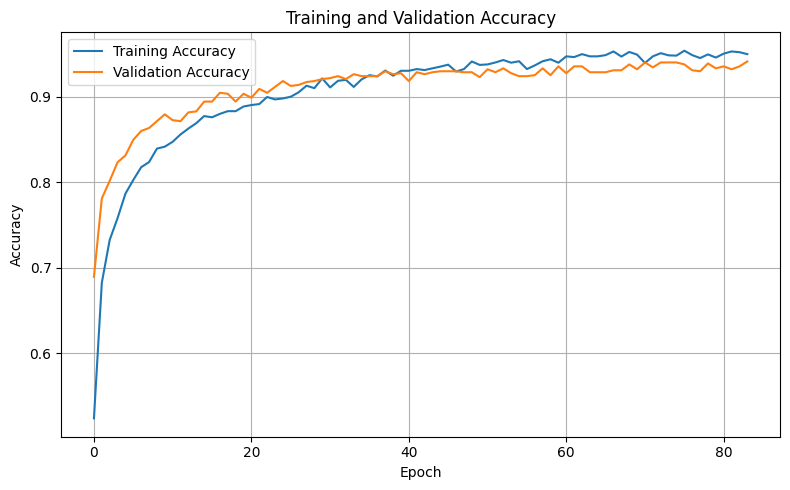

<Figure size 640x480 with 0 Axes>

In [373]:
plot_training_history(history)

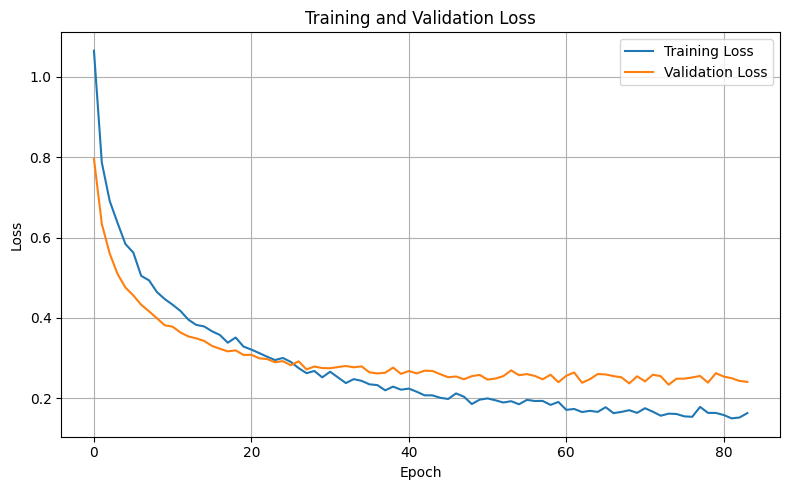

In [374]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

In [375]:
knn = KNeighborsClassifier(n_neighbors=3)  # Initialize KNN with 3 neighbors
knn.fit(X_train, y_train)                  # Train KNN on training data

KNeighborsClassifier(n_neighbors=3)

In [376]:
knn_pred = knn.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, knn_pred))

KNN Accuracy: 0.8598901098901099


<Axes: >

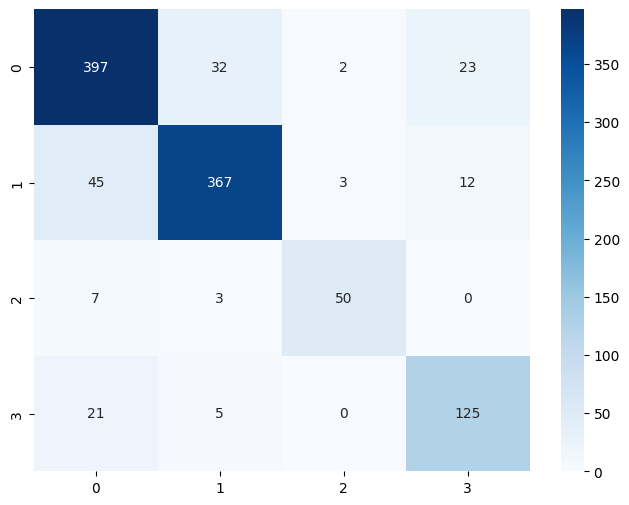

In [377]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test,knn.predict(X_test)), annot=True, fmt='d', cmap='Blues')

In [378]:
forest = RandomForestClassifier(n_estimators=200, random_state=42)  # Initialize Random Forest with 200 trees
forest.fit(X_train, y_train)                                       # Train on training data

RandomForestClassifier(n_estimators=200, random_state=42)

In [379]:
forest_pred = forest.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, forest_pred))

Random Forest Accuracy: 0.9935897435897436


<Axes: >

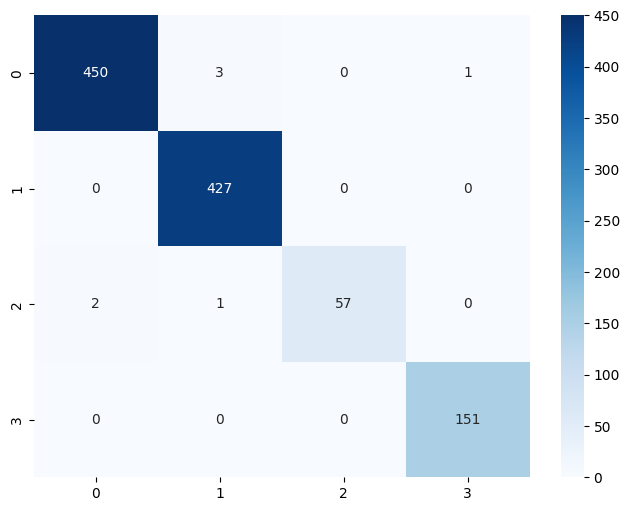

In [380]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test,forest.predict(X_test)), annot=True, fmt='d', cmap='Blues')

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


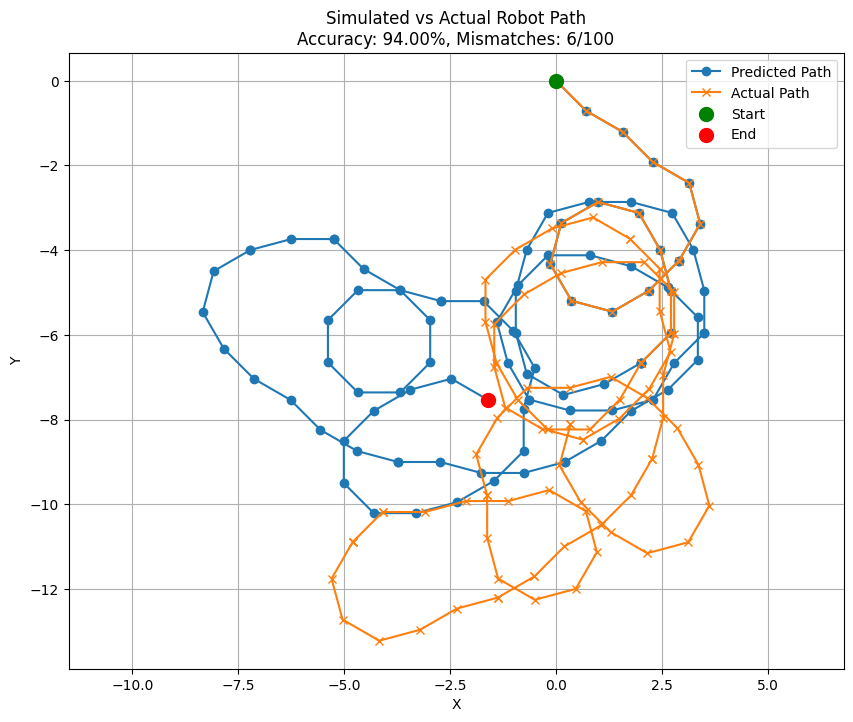

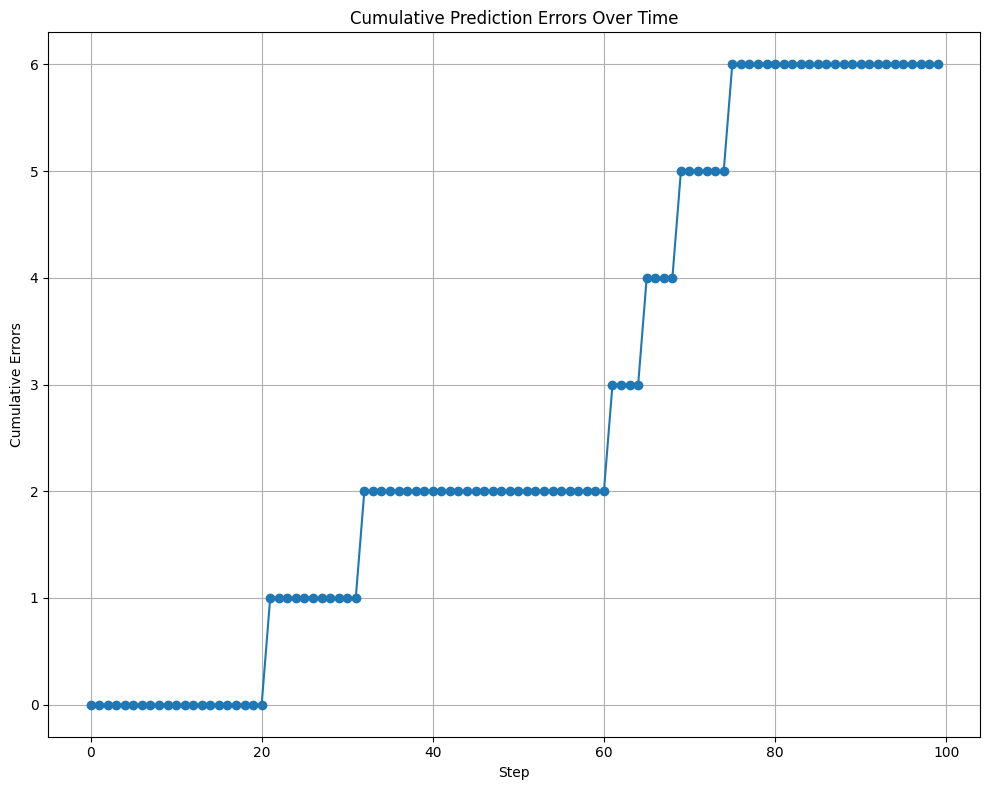

In [383]:
# Movement labels
movements = {
    0: "Move-Forward",
    1: "Slight-Right-Turn",
    2: "Sharp-Right-Turn",
    3: "Slight-Left-Turn"
}


y_true = y_test[700:800]
y_pred = model.predict(X_test_scaled)
y_pred = (np.argmax(y_pred, axis=1) + 1)[700:800]

# Simulated path (Predicted)
x, y = 0, 0
direction = 0
path_x = [x]
path_y = [y]

for move in y_pred:
    if move == 0:
        x += np.cos(np.radians(direction))
        y += np.sin(np.radians(direction))
    elif move == 1:
        direction -= 15
        x += np.cos(np.radians(direction))
        y += np.sin(np.radians(direction))
    elif move == 2:
        direction -= 45
        x += np.cos(np.radians(direction))
        y += np.sin(np.radians(direction))
    elif move == 3:
        direction += 15
        x += np.cos(np.radians(direction))
        y += np.sin(np.radians(direction))
    path_x.append(x)
    path_y.append(y)

# Real path (Ground Truth)
x_real, y_real = 0, 0
direction_real = 0
real_path_x = [x_real]
real_path_y = [y_real]

for move in y_true:
    if move == 0:
        x_real += np.cos(np.radians(direction_real))
        y_real += np.sin(np.radians(direction_real))
    elif move == 1:
        direction_real -= 15
        x_real += np.cos(np.radians(direction_real))
        y_real += np.sin(np.radians(direction_real))
    elif move == 2:
        direction_real -= 45
        x_real += np.cos(np.radians(direction_real))
        y_real += np.sin(np.radians(direction_real))
    elif move == 3:
        direction_real += 15
        x_real += np.cos(np.radians(direction_real))
        y_real += np.sin(np.radians(direction_real))
    real_path_x.append(x_real)
    real_path_y.append(y_real)

# Metrics
mismatch_count = np.sum(y_pred != y_true)
accuracy = (len(y_true) - mismatch_count) / len(y_true)
difference_evolution = (y_pred != y_true).astype(int)
cumulative_difference = np.cumsum(difference_evolution)

# Plot 1: Robot Path
plt.figure(figsize=(10, 8))
plt.plot(path_x, path_y, marker='o', label='Predicted Path')
plt.plot(real_path_x, real_path_y, marker='x', label='Actual Path')
plt.scatter(path_x[0], path_y[0], color='green', s=100, label='Start', zorder=5)
plt.scatter(path_x[-1], path_y[-1], color='red', s=100, label='End', zorder=5)
plt.title(f'Simulated vs Actual Robot Path\nAccuracy: {accuracy*100:.2f}%, Mismatches: {mismatch_count}/{len(y_true)}')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.savefig("robot_path.png")
plt.show()

# Plot 2: Error Evolution
plt.figure(figsize=(10, 8))
plt.plot(cumulative_difference, marker='o', linestyle='-')
plt.title('Cumulative Prediction Errors Over Time')
plt.xlabel('Step')
plt.ylabel('Cumulative Errors')
plt.grid(True)
plt.tight_layout()
plt.savefig("error_evolution.png")
plt.show()


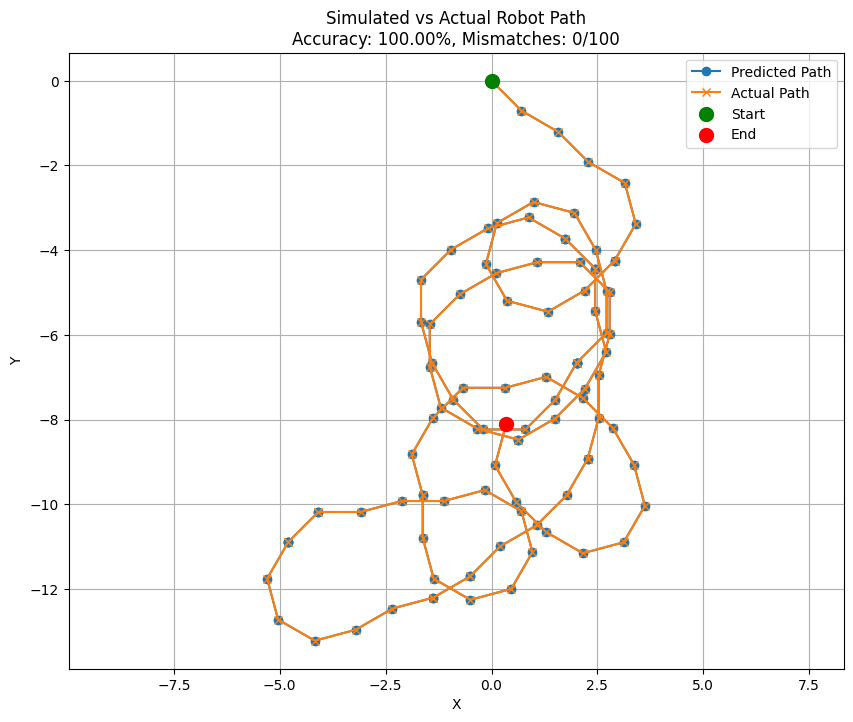

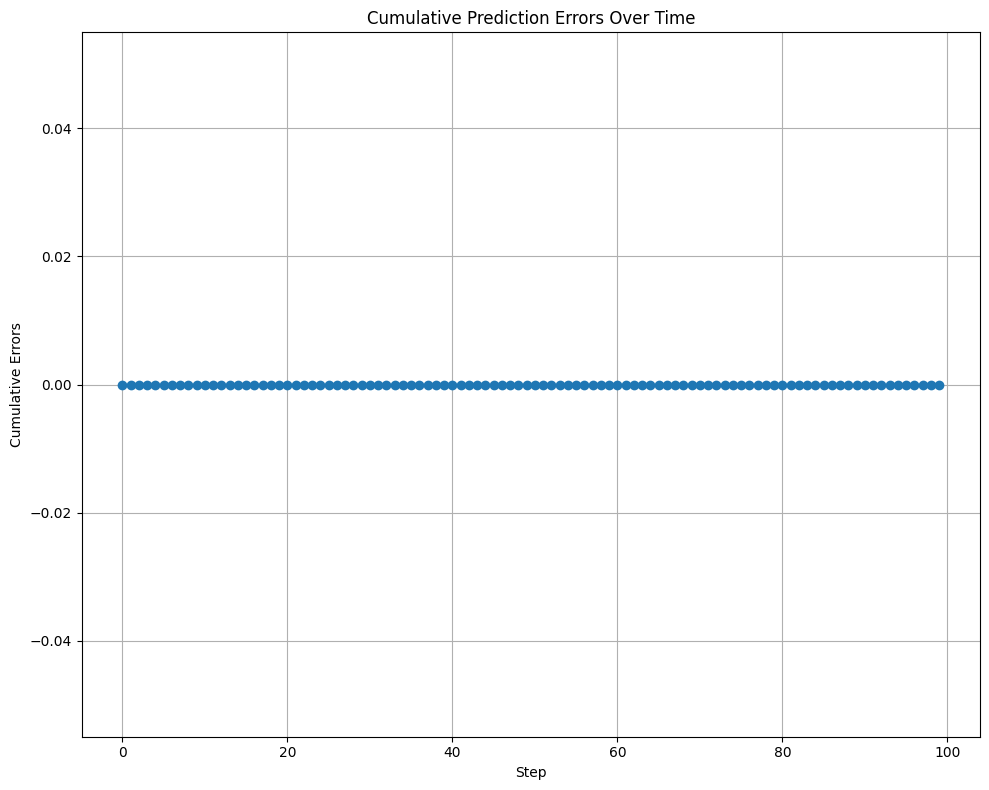

In [388]:
import matplotlib.pyplot as plt
import numpy as np

# Movement labels
movements = {
    0: "Move-Forward",
    1: "Slight-Right-Turn",
    2: "Sharp-Right-Turn",
    3: "Slight-Left-Turn"
}


start, end = 700, 800
y_true = y_test[start:end]
y_pred = forest.predict(X_test[start:end])

# Simulated path (Predicted)
x, y = 0, 0
direction = 0
path_x = [x]
path_y = [y]

for move in y_pred:
    if move == 0:
        x += np.cos(np.radians(direction))
        y += np.sin(np.radians(direction))
    elif move == 1:
        direction -= 15
        x += np.cos(np.radians(direction))
        y += np.sin(np.radians(direction))
    elif move == 2:
        direction -= 45
        x += np.cos(np.radians(direction))
        y += np.sin(np.radians(direction))
    elif move == 3:
        direction += 15
        x += np.cos(np.radians(direction))
        y += np.sin(np.radians(direction))
    path_x.append(x)
    path_y.append(y)

# Real path (Ground Truth)
x_real, y_real = 0, 0
direction_real = 0
real_path_x = [x_real]
real_path_y = [y_real]

for move in y_true:
    if move == 0:
        x_real += np.cos(np.radians(direction_real))
        y_real += np.sin(np.radians(direction_real))
    elif move == 1:
        direction_real -= 15
        x_real += np.cos(np.radians(direction_real))
        y_real += np.sin(np.radians(direction_real))
    elif move == 2:
        direction_real -= 45
        x_real += np.cos(np.radians(direction_real))
        y_real += np.sin(np.radians(direction_real))
    elif move == 3:
        direction_real += 15
        x_real += np.cos(np.radians(direction_real))
        y_real += np.sin(np.radians(direction_real))
    real_path_x.append(x_real)
    real_path_y.append(y_real)

# Metrics
mismatch_count = np.sum(y_pred != y_true)
accuracy = (len(y_true) - mismatch_count) / len(y_true)
difference_evolution = (y_pred != y_true).astype(int)
cumulative_difference = np.cumsum(difference_evolution)

# Plot 1: Robot Path
plt.figure(figsize=(10, 8))
plt.plot(path_x, path_y, marker='o', label='Predicted Path')
plt.plot(real_path_x, real_path_y, marker='x', label='Actual Path')
plt.scatter(path_x[0], path_y[0], color='green', s=100, label='Start', zorder=5)
plt.scatter(path_x[-1], path_y[-1], color='red', s=100, label='End', zorder=5)
plt.title(f'Simulated vs Actual Robot Path\nAccuracy: {accuracy*100:.2f}%, Mismatches: {mismatch_count}/{len(y_true)}')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.savefig("robot_path_rf.png")
plt.show()

# Plot 2: Error Evolution
plt.figure(figsize=(10, 8))
plt.plot(cumulative_difference, marker='o', linestyle='-')
plt.title('Cumulative Prediction Errors Over Time')
plt.xlabel('Step')
plt.ylabel('Cumulative Errors')
plt.grid(True)
plt.tight_layout()
plt.savefig("error_evolution_rf.png")
plt.show()

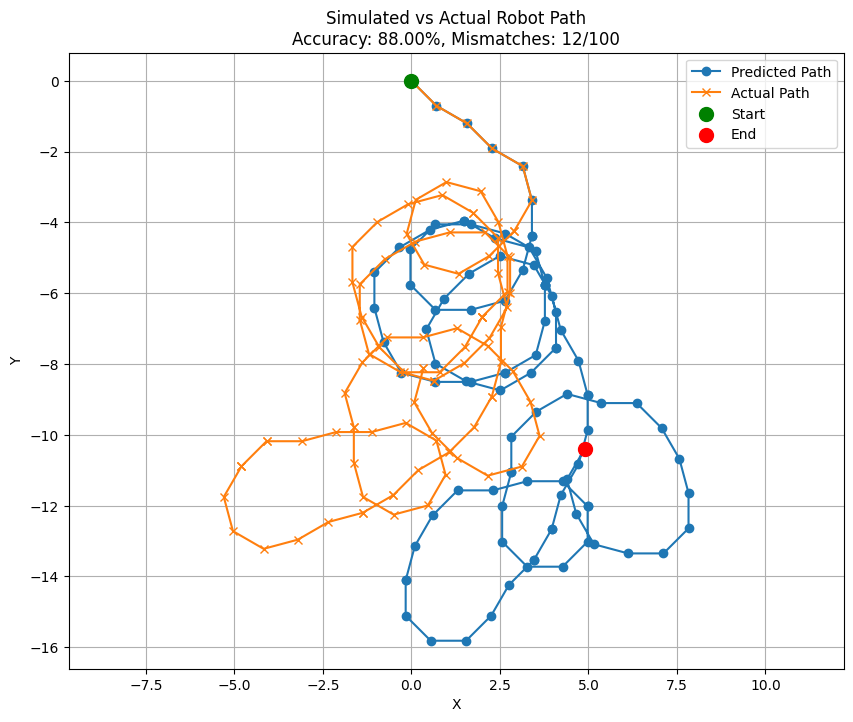

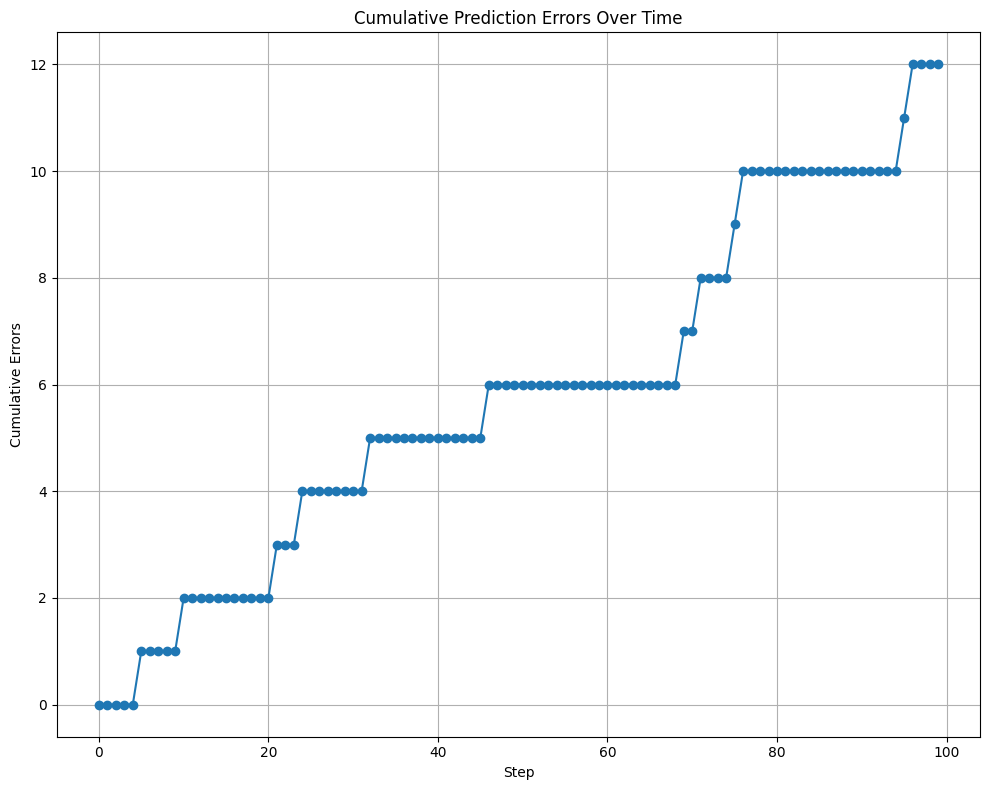

In [389]:
import matplotlib.pyplot as plt
import numpy as np

# Movement labels
movements = {
    0: "Move-Forward",
    1: "Slight-Right-Turn",
    2: "Sharp-Right-Turn",
    3: "Slight-Left-Turn"
}

start, end = 700, 800
y_true = y_test[start:end]
y_pred = knn.predict(X_test[start:end])

# Simulated path (Predicted)
x, y = 0, 0
direction = 0
path_x = [x]
path_y = [y]

for move in y_pred:
    if move == 0:
        x += np.cos(np.radians(direction))
        y += np.sin(np.radians(direction))
    elif move == 1:
        direction -= 15
        x += np.cos(np.radians(direction))
        y += np.sin(np.radians(direction))
    elif move == 2:
        direction -= 45
        x += np.cos(np.radians(direction))
        y += np.sin(np.radians(direction))
    elif move == 3:
        direction += 15
        x += np.cos(np.radians(direction))
        y += np.sin(np.radians(direction))
    path_x.append(x)
    path_y.append(y)

# Real path (Ground Truth)
x_real, y_real = 0, 0
direction_real = 0
real_path_x = [x_real]
real_path_y = [y_real]

for move in y_true:
    if move == 0:
        x_real += np.cos(np.radians(direction_real))
        y_real += np.sin(np.radians(direction_real))
    elif move == 1:
        direction_real -= 15
        x_real += np.cos(np.radians(direction_real))
        y_real += np.sin(np.radians(direction_real))
    elif move == 2:
        direction_real -= 45
        x_real += np.cos(np.radians(direction_real))
        y_real += np.sin(np.radians(direction_real))
    elif move == 3:
        direction_real += 15
        x_real += np.cos(np.radians(direction_real))
        y_real += np.sin(np.radians(direction_real))
    real_path_x.append(x_real)
    real_path_y.append(y_real)

# Metrics
mismatch_count = np.sum(y_pred != y_true)
accuracy = (len(y_true) - mismatch_count) / len(y_true)
difference_evolution = (y_pred != y_true).astype(int)
cumulative_difference = np.cumsum(difference_evolution)

# Plot 1: Robot Path
plt.figure(figsize=(10, 8))
plt.plot(path_x, path_y, marker='o', label='Predicted Path')
plt.plot(real_path_x, real_path_y, marker='x', label='Actual Path')
plt.scatter(path_x[0], path_y[0], color='green', s=100, label='Start', zorder=5)
plt.scatter(path_x[-1], path_y[-1], color='red', s=100, label='End', zorder=5)
plt.title(f'Simulated vs Actual Robot Path\nAccuracy: {accuracy*100:.2f}%, Mismatches: {mismatch_count}/{len(y_true)}')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.savefig("robot_path_knn.png")
plt.show()

# Plot 2: Error Evolution
plt.figure(figsize=(10, 8))
plt.plot(cumulative_difference, marker='o', linestyle='-')
plt.title('Cumulative Prediction Errors Over Time')
plt.xlabel('Step')
plt.ylabel('Cumulative Errors')
plt.grid(True)
plt.tight_layout()
plt.savefig("error_evolution_knn.png")
plt.show()